In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from math import sqrt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from arch import arch_model

In [2]:
df = pd.read_csv('MSN.csv')
df.head()

,Ticker,Date/Time,Open,High,Low,Close,Volume,Open Interest
0,MSN,12/25/2017 9:15,73.1,73.1,73.1,73.1,4210,0
1,MSN,12/25/2017 9:16,73.0,73.0,73.0,73.0,5000,0
2,MSN,12/25/2017 9:18,73.5,73.5,73.5,73.5,210,0
3,MSN,12/25/2017 9:20,73.2,73.5,73.1,73.1,2050,0
4,MSN,12/25/2017 9:21,73.0,73.0,73.0,73.0,1380,0


In [3]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df['Date/Time'] = df['Date/Time'].dt.date

In [4]:
df['Date/Time'] = pd.to_datetime(df['Date/Time'])
df.drop(columns=['Ticker', 'Open Interest'], inplace=True)
df.set_index('Date/Time', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 135354 entries, 2017-12-25 to 2020-12-22
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Open    135354 non-null  float64
 1   High    135354 non-null  float64
 2   Low     135354 non-null  float64
 3   Close   135354 non-null  float64
 4   Volume  135354 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 6.2 MB


In [5]:
agg_functions = {
    'Open': 'first',
    'High': 'max',
    'Low': 'min',
    'Close': 'last',
    'Volume': 'sum'
}
df = df.resample('D').agg(agg_functions).dropna()

In [6]:
df['Price Change'] = df['Close'].diff()
df['Percentage Returns'] = 100 * df['Close'].pct_change()
df.dropna(subset=['Price Change'], inplace=True)
df

,Open,High,Low,Close,Volume,Price Change,Percentage Returns
Date/Time,,,,,,,
2017-12-26,74.90,75.5,74.30,75.5,403710,1.3,1.752022
2017-12-27,74.90,75.7,74.80,75.0,517920,-0.5,-0.662252
2017-12-28,75.00,76.0,74.50,75.7,377030,0.7,0.933333
2017-12-29,76.00,77.0,76.00,76.7,226880,1.0,1.321004
2018-01-02,77.00,80.0,76.70,80.0,533950,3.3,4.302477
...,...,...,...,...,...,...,...
2020-12-16,83.01,83.6,82.91,83.5,648540,0.0,0.000000
2020-12-17,83.50,84.3,82.90,84.0,1179730,0.5,0.598802
2020-12-18,83.70,84.3,83.70,84.1,1417470,0.1,0.119048


In [7]:
def stationarity_check(station_data):
    # Calculate rolling mean and standard deviation
    roll_mean = station_data.rolling(30, center= True, closed= 'both').mean()
    roll_std = station_data.rolling(10, center= True, closed= 'both').std()
    
    # Plot data, rolling mean and standard deviation
    fig = plt.figure(figsize= (16,10))
    plt.subplot(211)
    plt.plot(station_data, color= 'green', label= 'Original Data')
    plt.plot(roll_mean, color= 'black', label= 'Rolling Mean (30 days)')
    plt.legend()
    plt.subplot(212)
    plt.plot(roll_std, color= 'orange', label= 'Rolling Std (10 days)')
    plt.legend()
    plt.show()
    
    # Perform Augmented Dickey-Fuller test
    result = adfuller(station_data.dropna(), autolag= 'AIC')
    print('Dickey-Fuller test results\n')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for cv, r in result[4].items():
        print('\t%s: %.3f' % (cv, r))

## 1. Price Change Volatility

In [8]:
price_change = df['Price Change']

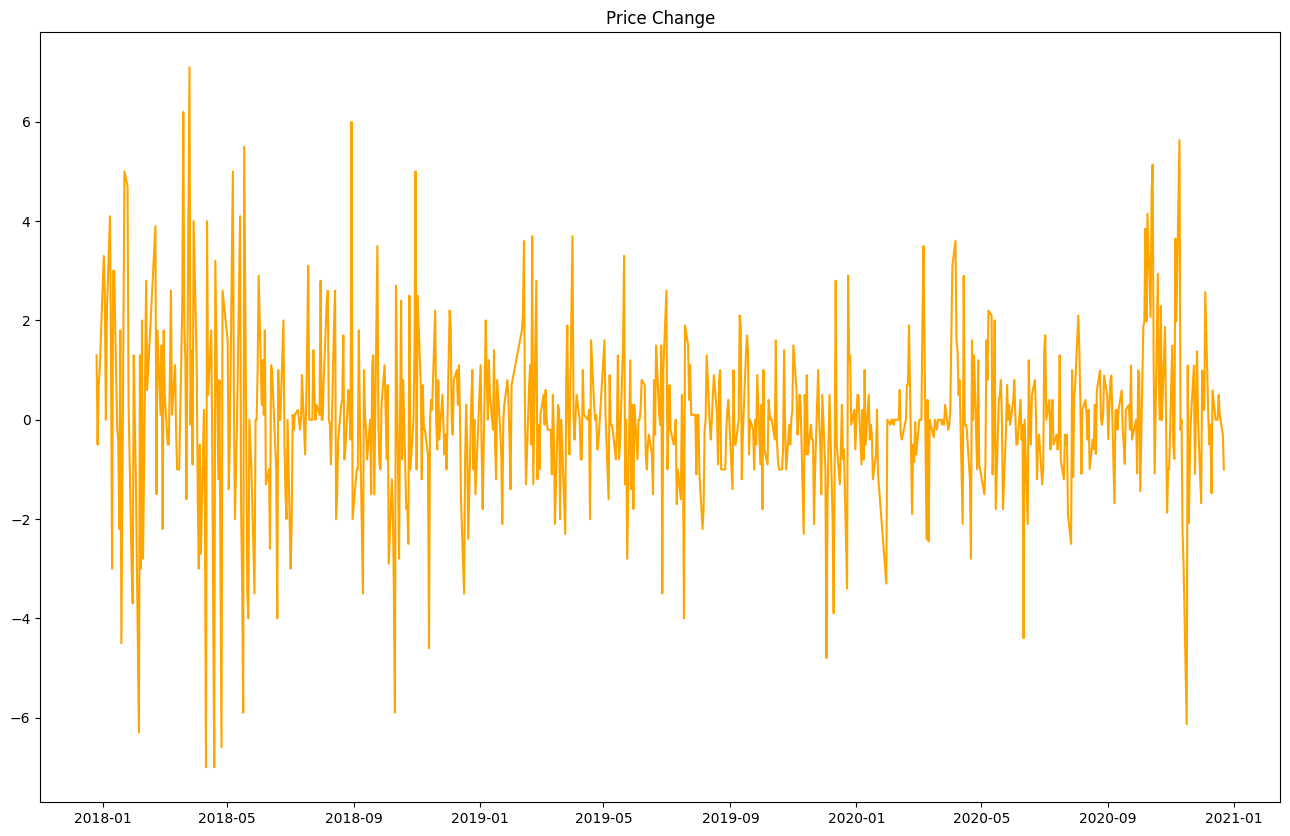

In [9]:
plt.figure(figsize= (16,10))
plt.title('Price Change')
plt.plot(price_change, color= 'orange')
plt.show()

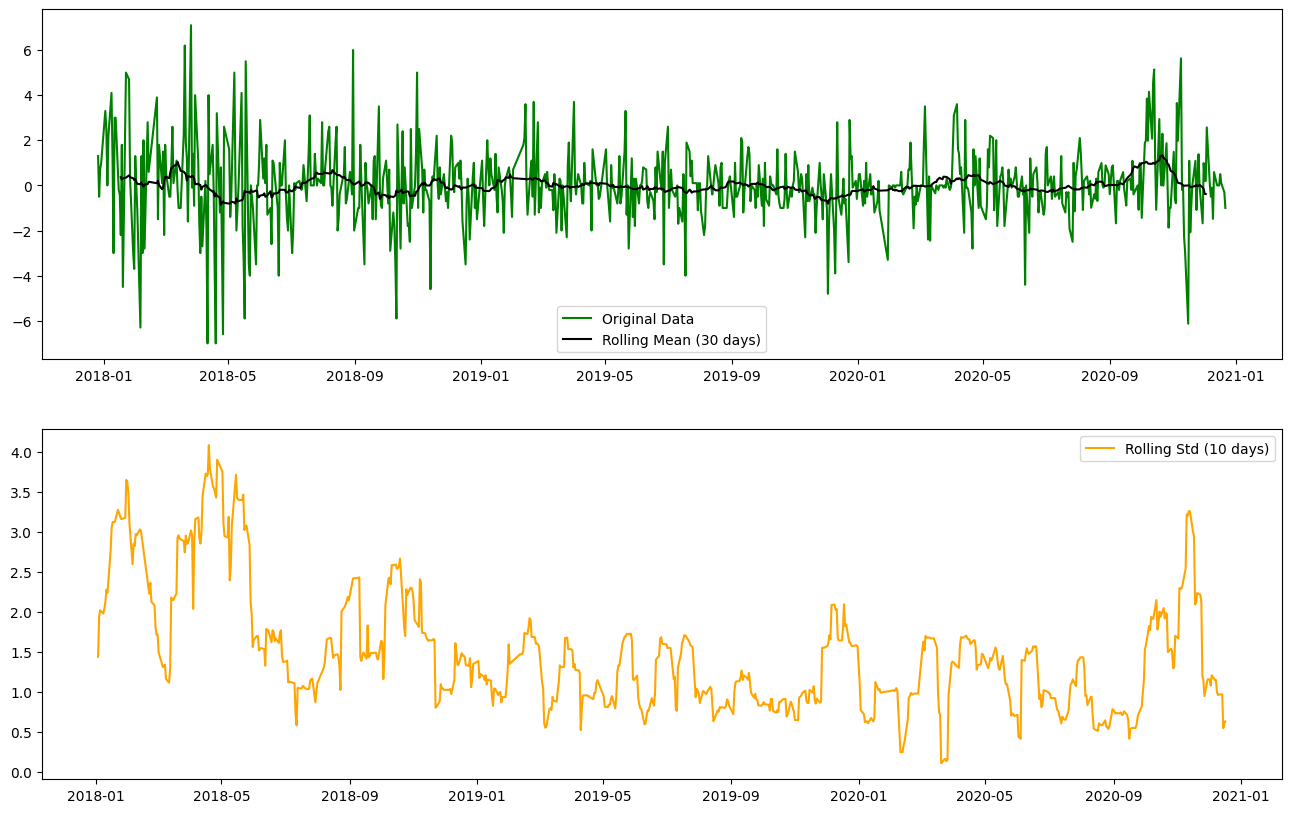

Dickey-Fuller test results

ADF Statistic: -7.280157463251093
p-value: 1.5077526060227434e-10
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [10]:
stationarity_check(price_change)

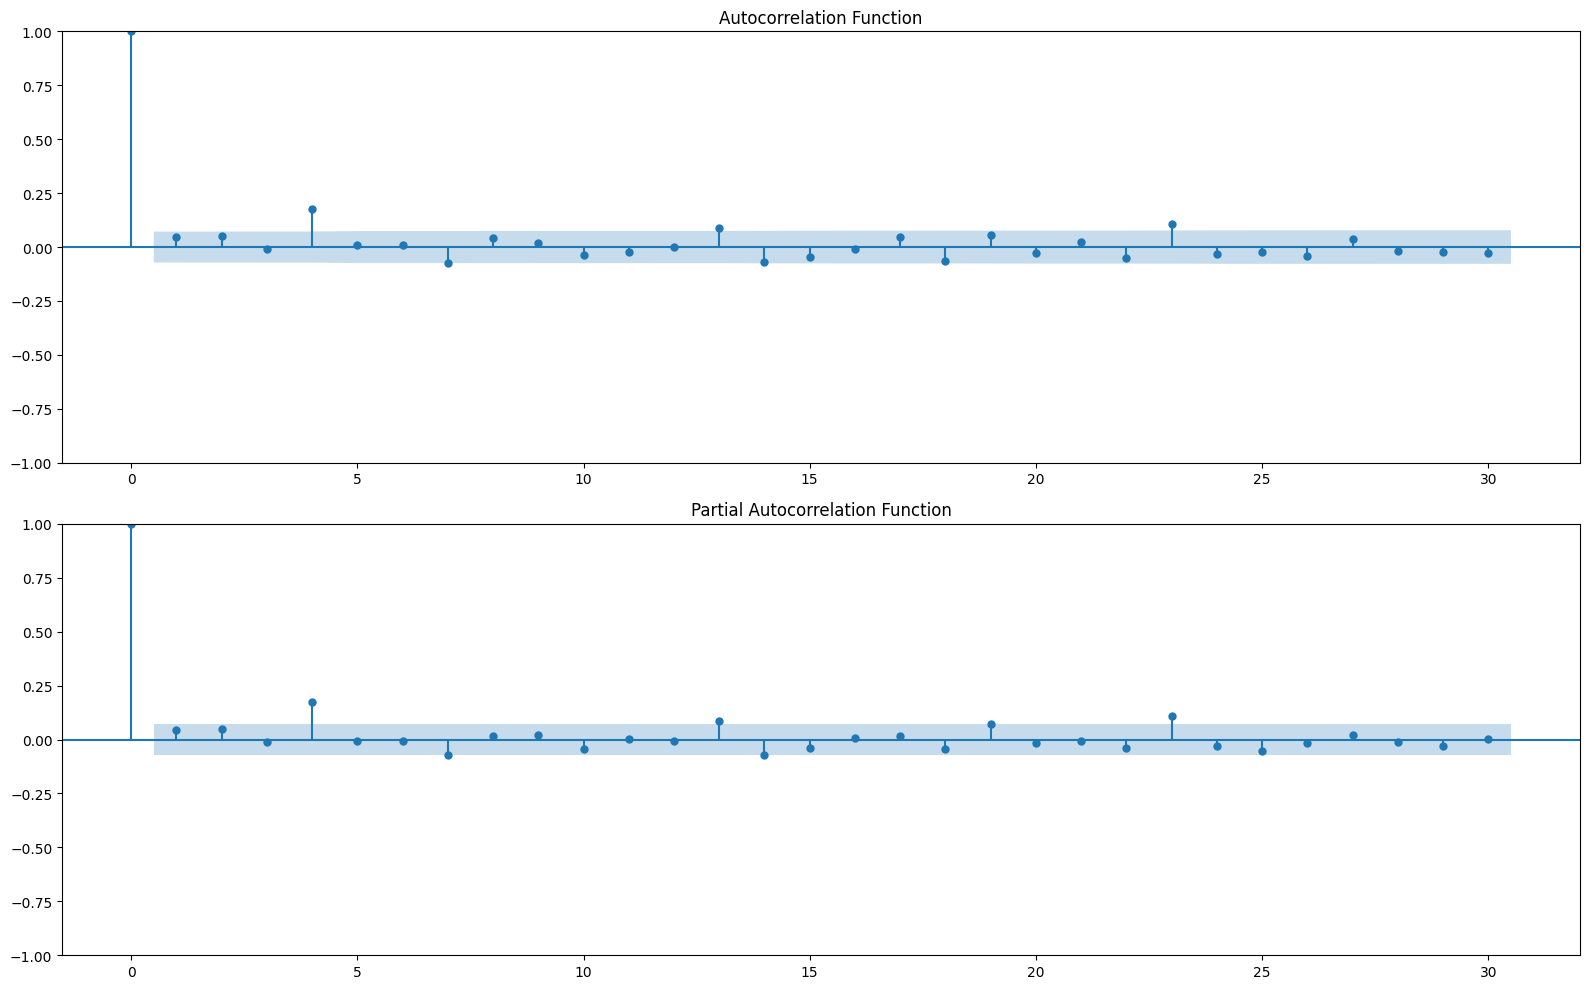

In [11]:
# Plot ACF and PACF functions
fig, ax = plt.subplots(2, figsize= (16, 10))
plot_acf(price_change, ax= ax[0], lags= 30)
ax[0].set(title='Autocorrelation Function')
plot_pacf(price_change, ax= ax[1], lags= 30)
ax[1].set(title= 'Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

### 1.1. ARIMA Model

In [12]:
auto_arima_model = auto_arima(price_change, seasonal= False, trace=True)
auto_arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=2880.143, Time=0.25 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=2883.085, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=2883.604, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=2883.737, Time=0.04 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=2877.976, Time=0.17 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=2884.301, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=2881.197, Time=0.09 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=2878.032, Time=0.23 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=2885.840, Time=0.09 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=2879.029, Time=0.11 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=2880.488, Time=0.33 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=2879.946, Time=0.43 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 1.873 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  747
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -1434.988
Date:                Mon, 04 Dec 2023   AIC                           2877.976
Time:                        15:02:03   BIC                           2896.441
Sample:                             0   HQIC                          2885.092
                                - 747                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7992      0.108     -7.383      0.000      -1.011      -0.587
ma.L1          0.8605      0.109      7.888      0.000       0.647       1.074
ma.L2          0.1173      0.029      4.098      0.000       0.061       0.173
sigma2         2.7293      0.094     28.914      0.000       2.544       2.914
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):               239.79
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):               0.38   Skew:                            -0.00
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.78
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [13]:
arima_01 = ARIMA(price_change, order=(1,0,2))
arima_model_01 = arima_01.fit()
arima_predictions_01 = arima_model_01.predict()

c:\Users\Admins\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admins\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Admins\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


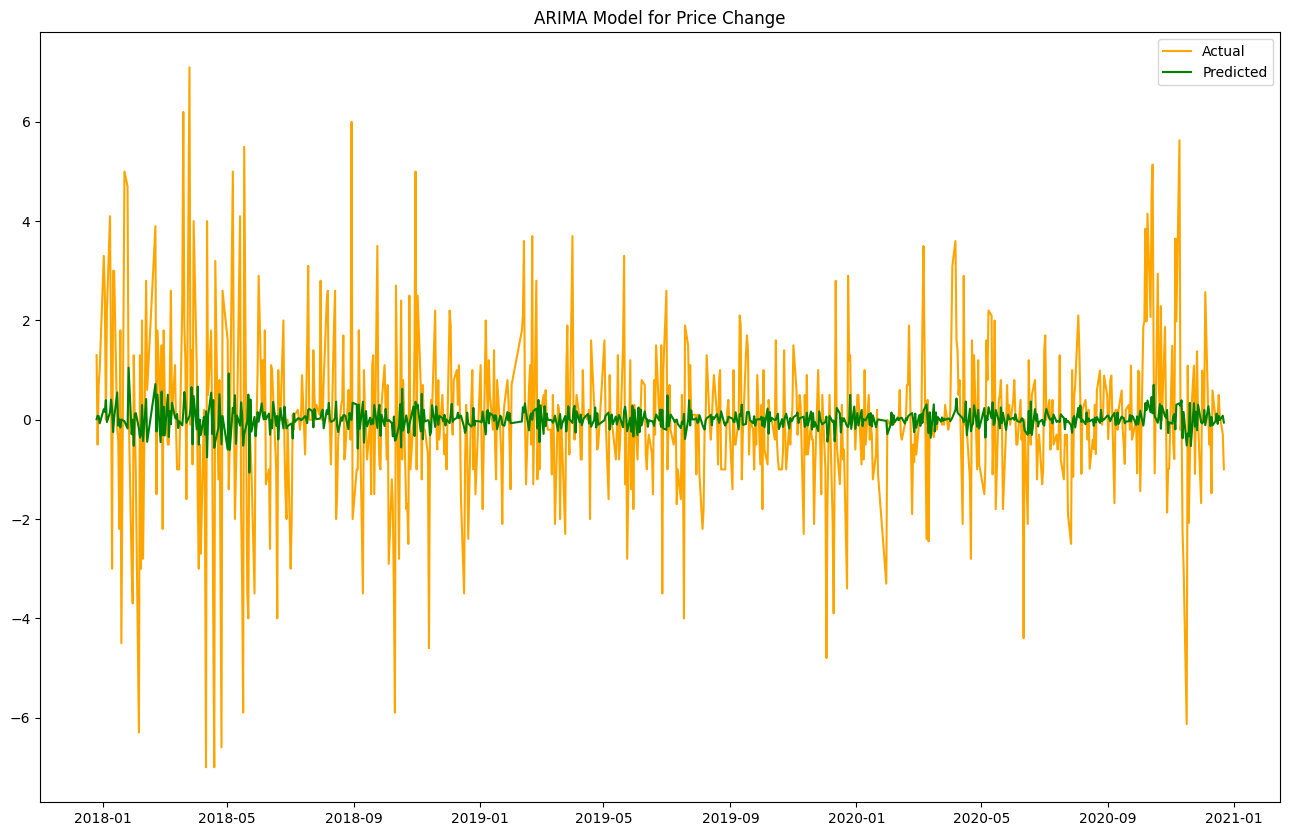

In [14]:
plt.figure(figsize= (16,10))
plt.title('ARIMA Model for Price Change')
plt.plot(price_change, color= 'orange', label= 'Actual')
plt.plot(arima_predictions_01, color= 'green', label= 'Predicted')
plt.legend()
plt.show()

### 1.2. GARCH Model

In [15]:
def fit_garch_model(data, p, o, q, mean, vol, dist):
    model = arch_model(data, p=p, o=o, q=q, mean=mean, vol=vol, dist=dist)
    res = model.fit(disp='off')
    return res.aic

In [16]:
def grid_search_garch(data, max_p, max_o, max_q, mean, vol, dist):
    best_aic = float('inf')
    best_params = None

    for p in range(1, max_p + 1):
        for o in range(1, max_o + 1):
            for q in range(1, max_q + 1):
                aic = fit_garch_model(data, p, o, q, mean, vol, dist)
                if aic < best_aic:
                    best_aic = aic
                    best_params = (p, o, q)
    return best_aic, best_params

In [17]:
max_p = 6
max_o = 6
max_q = 6

best_aic_01, best_params_01 = grid_search_garch(price_change, max_p, max_o, max_q, mean='constant', vol='garch', dist='t')

print(f"Best AIC: {best_aic_01}")
print(f"Best Parameters (p, o, q): {best_params_01}")

Best AIC: 2653.3287235735174
Best Parameters (p, o, q): (1, 1, 3)


In [18]:
garch_01 = arch_model(
    price_change, 
    p= 1, o= 1, q= 3, 
    mean = 'constant',
    vol = 'garch',
    dist = 't')
garch_model_01 = garch_01.fit(disp='off')
garch_model_01.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - GJR-GARCH Model Results                       
====================================================================================
Dep. Variable:                 Price Change   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -1318.66
Distribution:      Standardized Student's t   AIC:                           2653.33
Method:                  Maximum Likelihood   BIC:                           2690.26
                                              No. Observations:                  747
Date:                      Mon, Dec 04 2023   Df Residuals:                      746
Time:                              15:02:54   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.0471  3.879e-02     -1.215      0.224 [ -0.123,2.888e-02]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1913      0.114      1.682  9.253e-02 [-3.158e-02,  0.414]
alpha[1]       0.3995      0.141      2.831  4.638e-03    [  0.123,  0.676]
gamma[1]      -0.1724      0.121     -1.426      0.154  [ -0.409,6.454e-02]
beta[1]        0.0000      0.143      0.000      1.000    [ -0.279,  0.279]
beta[2]        0.1130      0.120      0.942      0.346    [ -0.122,  0.348]
beta[3]        0.5686      0.327      1.739  8.203e-02 [-7.224e-02,  1.209]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             3.4497      0.500      6.899  5.237e-12 [  2.470,  4.430]
========================================================================

Covariance estimator: robust
"""

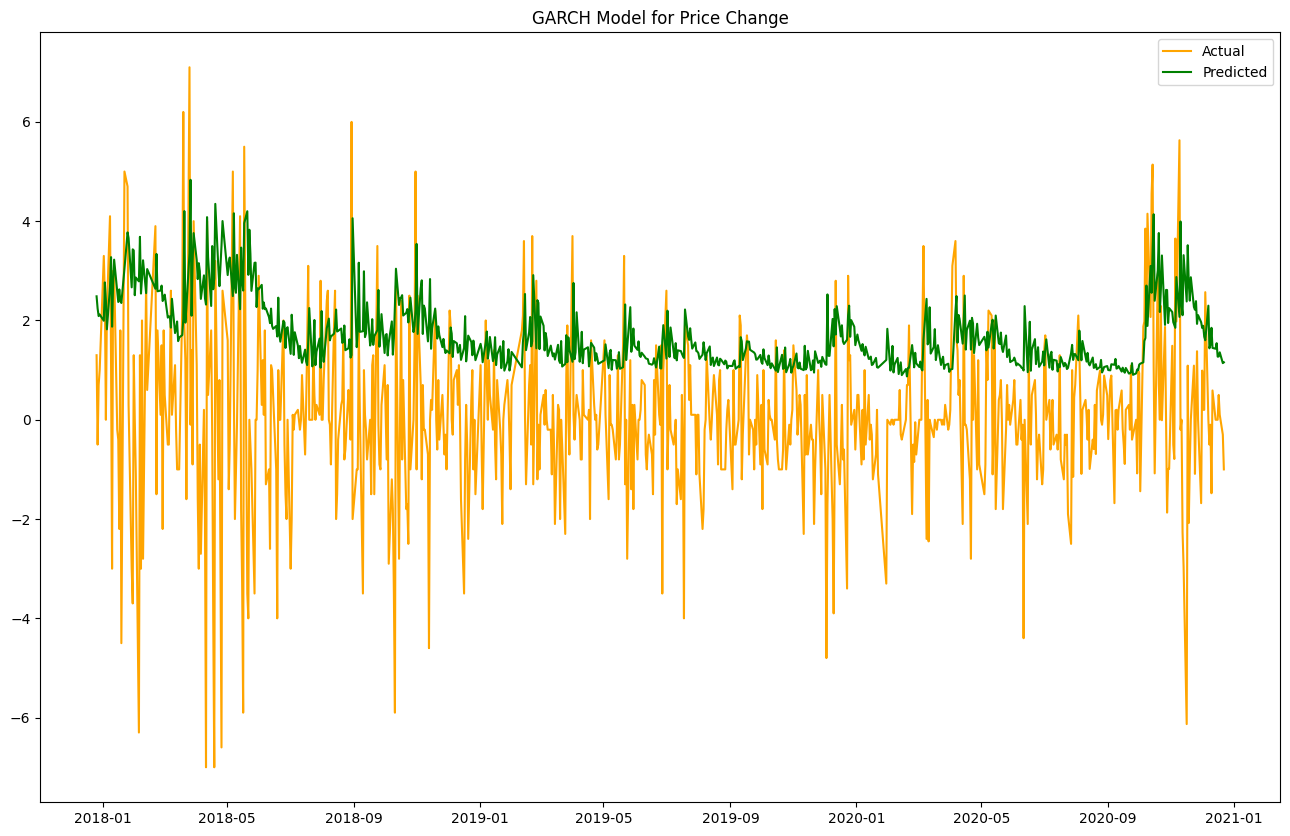

In [19]:
garch_result_01 = garch_model_01.conditional_volatility
plt.figure(figsize= (16,10))
plt.title('GARCH Model for Price Change')
plt.plot(price_change, color= 'orange', label= 'Actual')
plt.plot(garch_result_01, color= 'green', label= 'Predicted')
plt.legend()
plt.show()

### 1.3. ARIMA-GARCH Model

In [20]:
arima_residuals_01 = arima_model_01.resid

arima_garch_01 = arch_model(
    price_change, 
    p= 1, o= 1, q= 3, 
    mean = 'constant',
    vol = 'garch',
    dist = 't')
arima_garch_model_01 = arima_garch_01.fit(disp='off')
arima_garch_model_01.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - GJR-GARCH Model Results                       
====================================================================================
Dep. Variable:                 Price Change   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -1318.66
Distribution:      Standardized Student's t   AIC:                           2653.33
Method:                  Maximum Likelihood   BIC:                           2690.26
                                              No. Observations:                  747
Date:                      Mon, Dec 04 2023   Df Residuals:                      746
Time:                              15:02:55   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.0471  3.879e-02     -1.215      0.224 [ -0.123,2.888e-02]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          0.1913      0.114      1.682  9.253e-02 [-3.158e-02,  0.414]
alpha[1]       0.3995      0.141      2.831  4.638e-03    [  0.123,  0.676]
gamma[1]      -0.1724      0.121     -1.426      0.154  [ -0.409,6.454e-02]
beta[1]        0.0000      0.143      0.000      1.000    [ -0.279,  0.279]
beta[2]        0.1130      0.120      0.942      0.346    [ -0.122,  0.348]
beta[3]        0.5686      0.327      1.739  8.203e-02 [-7.224e-02,  1.209]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             3.4497      0.500      6.899  5.237e-12 [  2.470,  4.430]
========================================================================

Covariance estimator: robust
"""

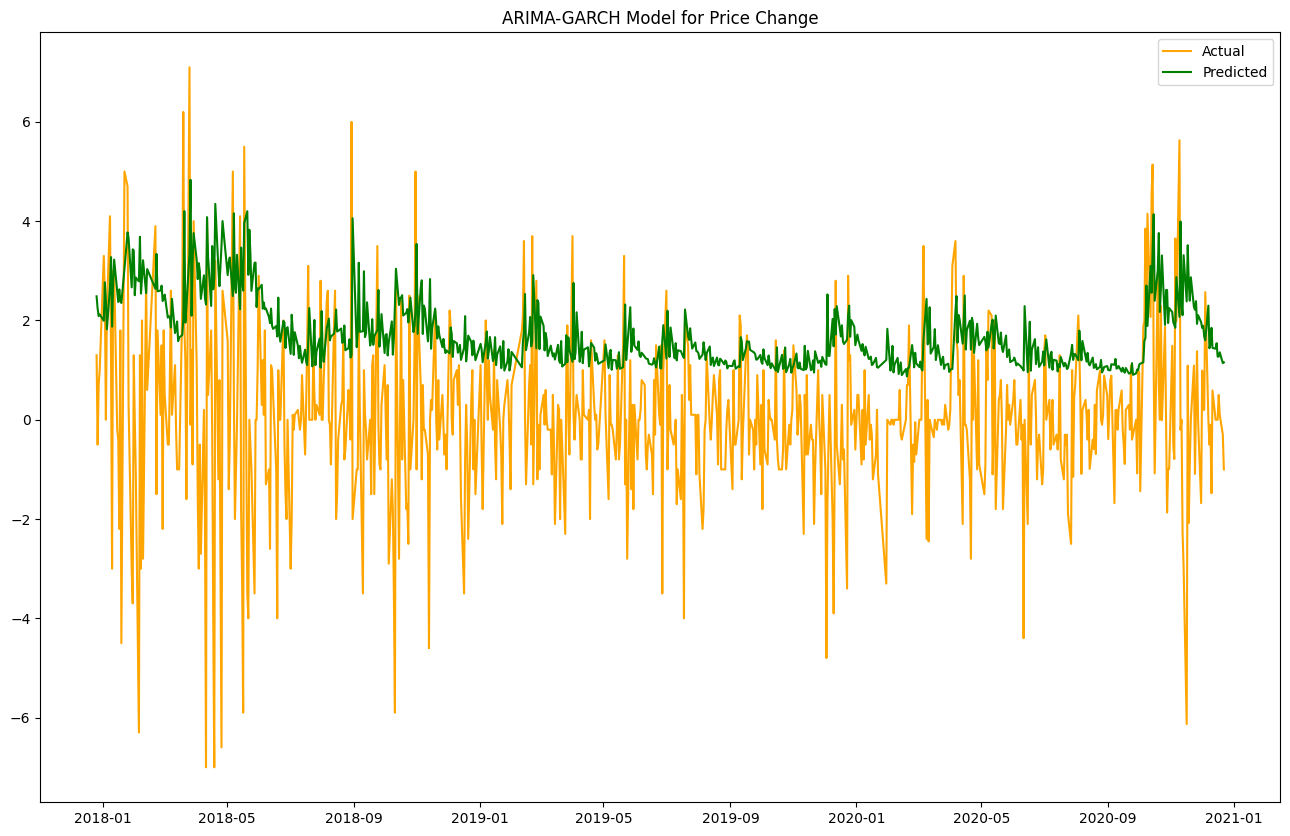

In [21]:
arima_garch_result_01 = arima_garch_model_01.conditional_volatility
plt.figure(figsize= (16,10))
plt.title('ARIMA-GARCH Model for Price Change')
plt.plot(price_change, color= 'orange', label= 'Actual')
plt.plot(arima_garch_result_01, color= 'green', label= 'Predicted')
plt.legend()
plt.show()

### 1.4. Rolling ARIMA-GARCH Model

In [22]:
split_index = int(len(price_change) * 0.8)

train_price_change = price_change[:split_index]
test_price_change = price_change[split_index:]

In [23]:
window_size = 30

train_price_change_arr = train_price_change.values
test_price_change_arr = test_price_change.values

# Initialise lists with training data and predictions
history_price_change_arr = [x for x in train_price_change_arr]
rolling_predictions_01 = []

In [24]:
warnings.filterwarnings('ignore')

# Iterate through test data and make predictions
for t in range(len(test_price_change_arr)):
    # Fit ARIMA model on the most recent observations
    start = max(0, len(history_price_change_arr) - window_size)
    end = len(history_price_change_arr)
    # Fit the ARIMA model on the rolling window
    arima = ARIMA(history_price_change_arr[start:end], order=(1, 0, 2))
    arima_model = arima.fit()
    
    # Get the residuals from the ARIMA model
    arima_residuals = arima_model.resid
    
    # Fit the GARCH model to the ARIMA residuals
    arima_garch = arch_model(
        arima_residuals, 
        p= 1, o= 1, q= 3, 
        mean = 'constant',
        vol = 'garch',
        dist = 't')
    arima_garch_model = arima_garch.fit(disp='off')


    # Make forecast and update lists
    output = arima_garch_model.forecast()
    rolling_volatility = np.sqrt(output.variance.values[-1,:][0])
    rolling_predictions_01.append(rolling_volatility)
    obs = test_price_change_arr[t]
    history_price_change_arr.append(obs)

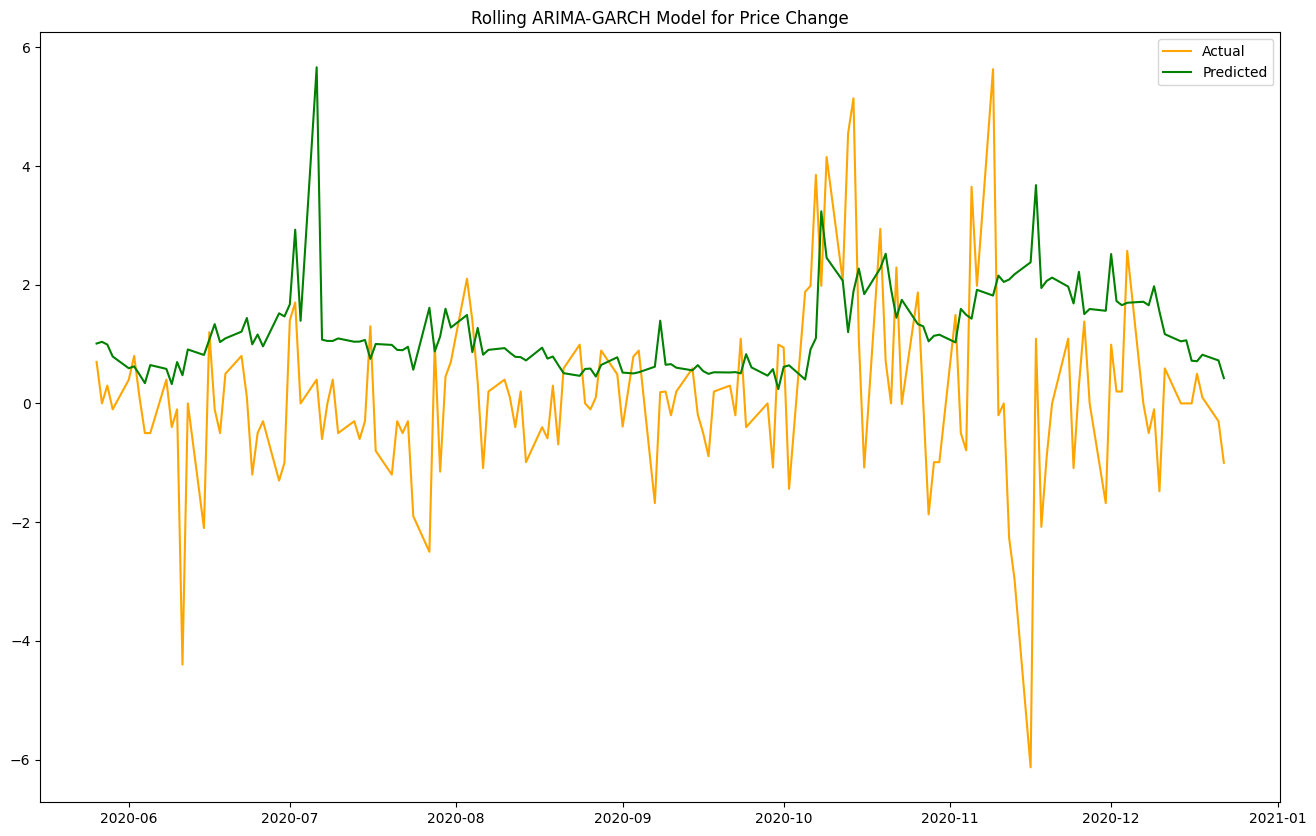

In [25]:
plt.figure(figsize= (16,10))
plt.title('Rolling ARIMA-GARCH Model for Price Change')
plt.plot(test_price_change.index, test_price_change, color= 'orange', label= 'Actual')
plt.plot(test_price_change.index, rolling_predictions_01, color= 'green', label= 'Predicted')
plt.legend()
plt.show()

## 2. Percentage Return Volatility

In [26]:
pct_returns = df['Percentage Returns']

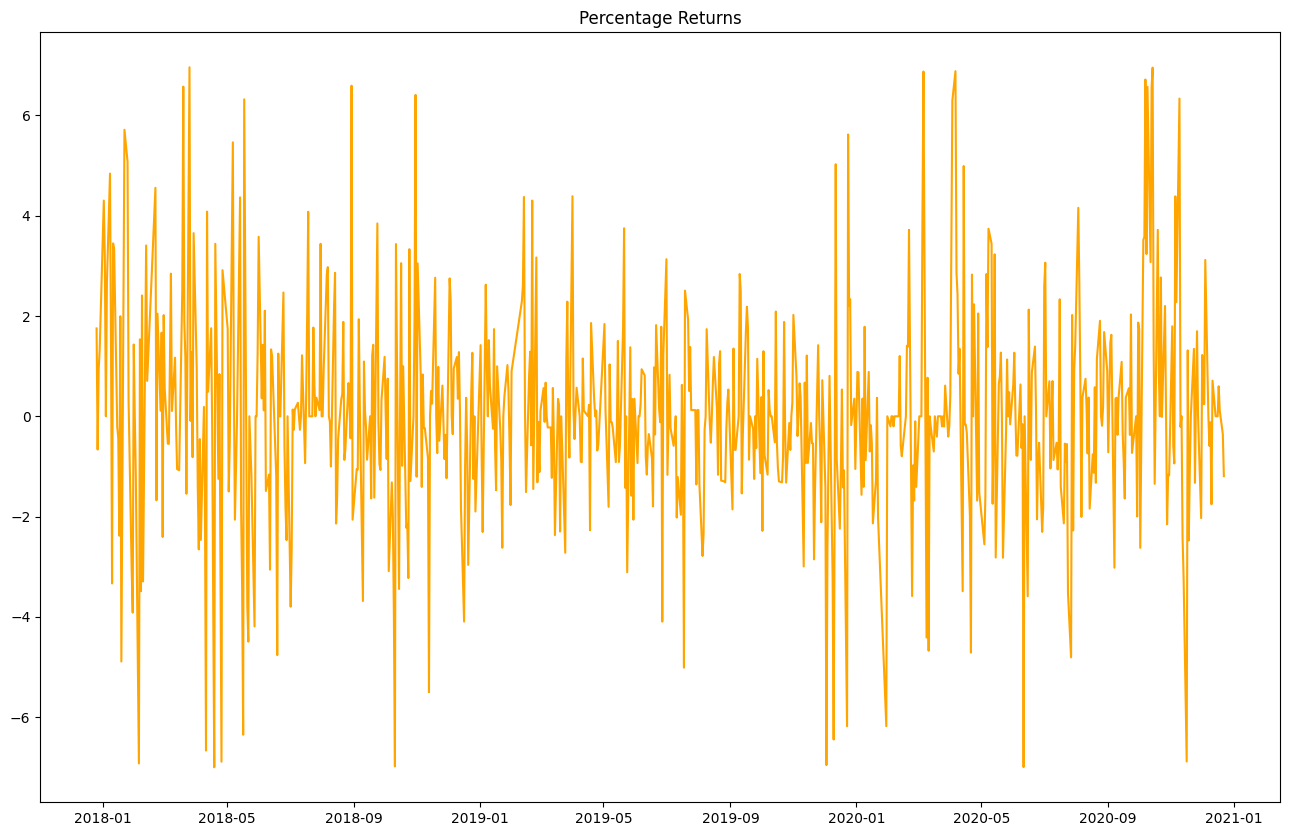

In [27]:
plt.figure(figsize= (16,10))
plt.title('Percentage Returns')
plt.plot(pct_returns, color= 'orange')
plt.show()

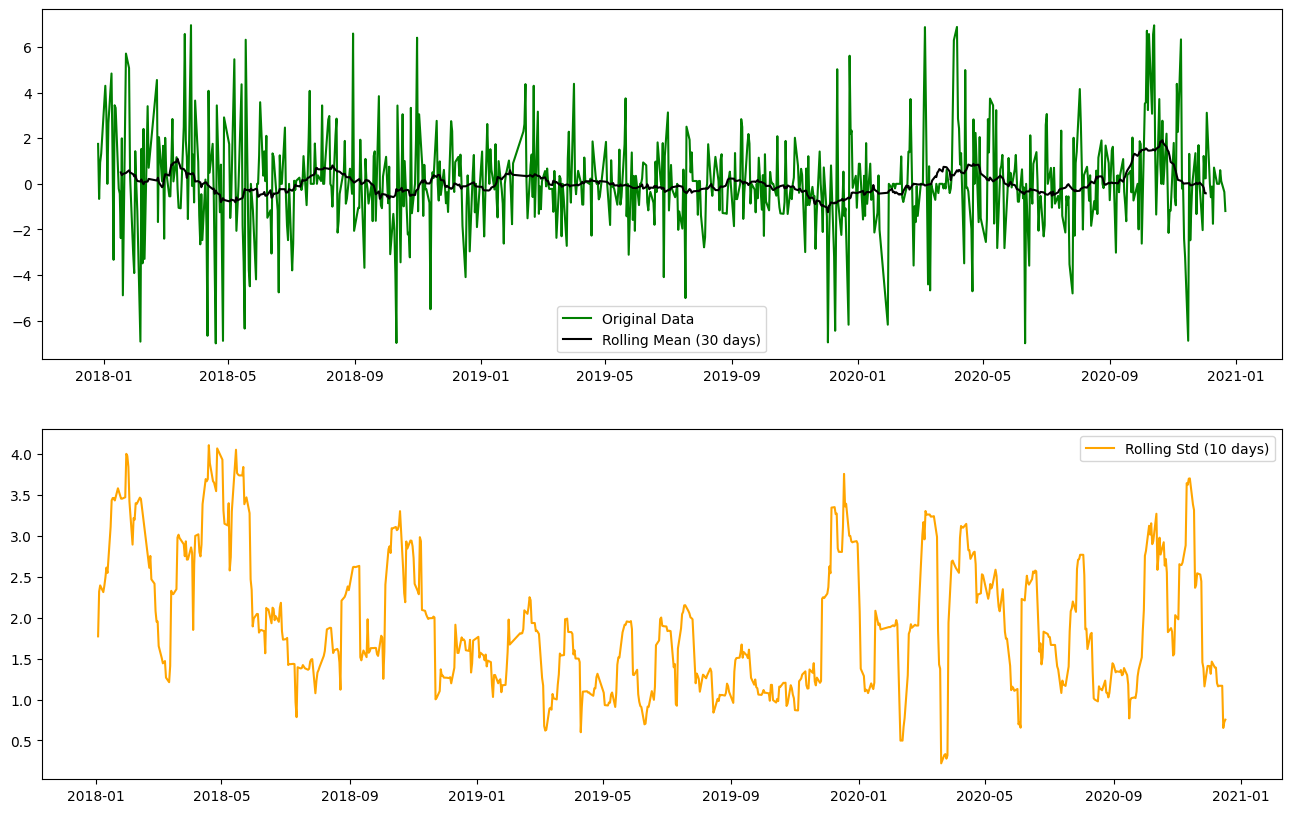

Dickey-Fuller test results

ADF Statistic: -9.834877451193064
p-value: 4.925677758882827e-17
Critical Values:
	1%: -3.439
	5%: -2.865
	10%: -2.569


In [28]:
stationarity_check(pct_returns)

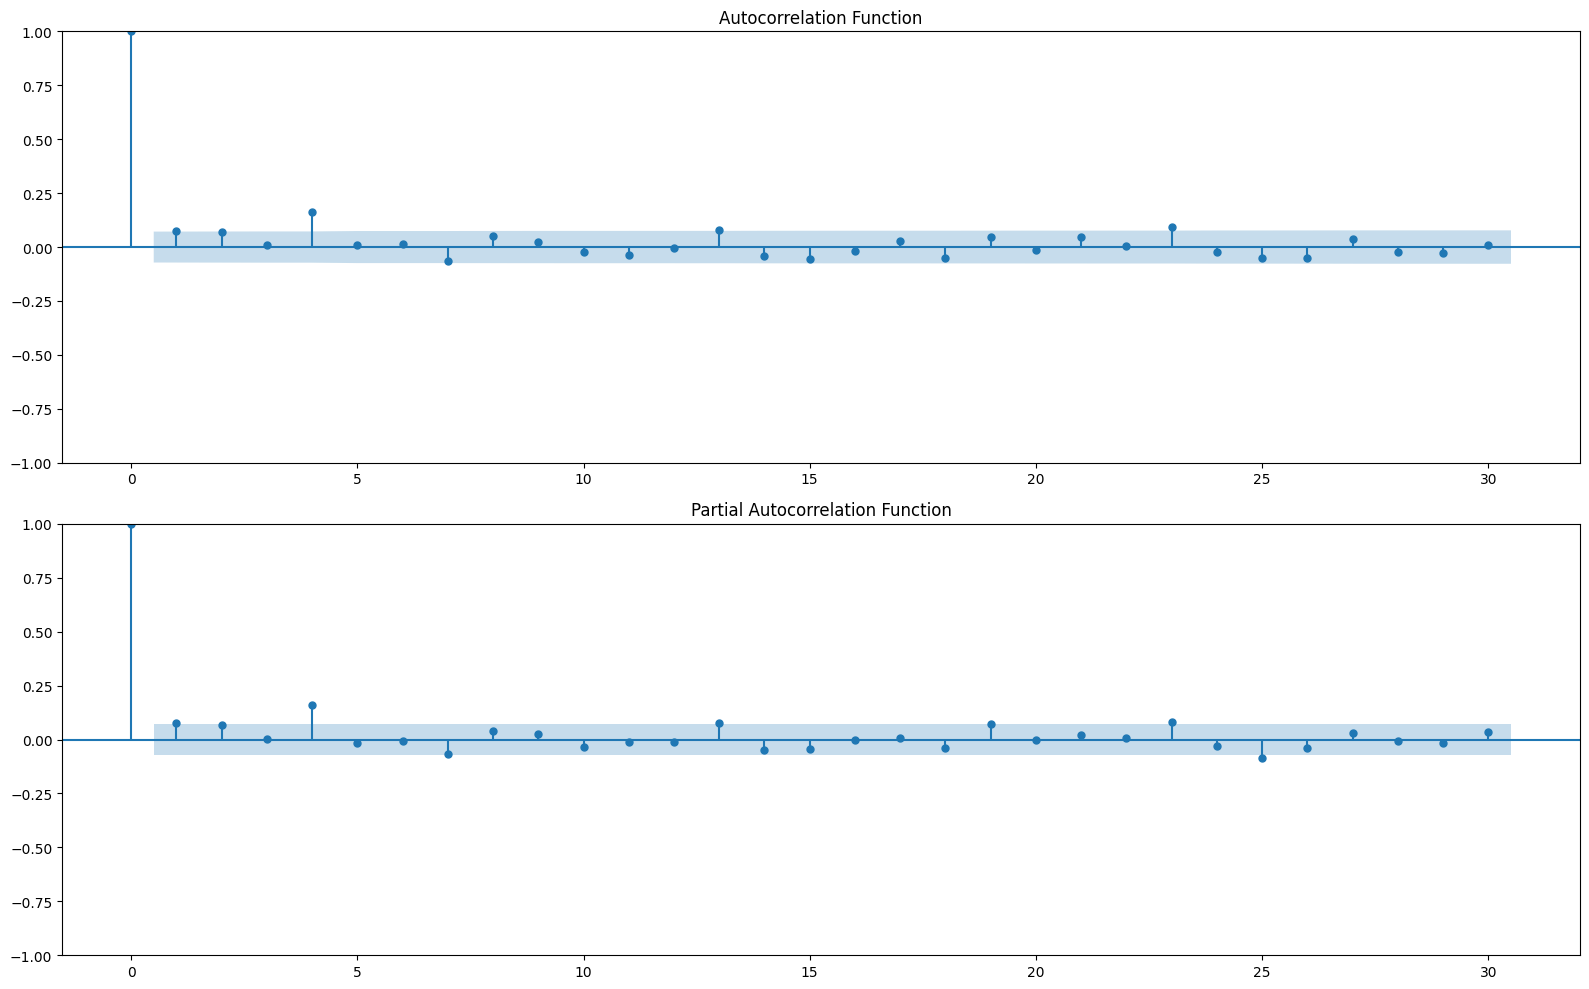

In [29]:
# Plot ACF and PACF functions
fig, ax = plt.subplots(2, figsize= (16, 10))
plot_acf(pct_returns, ax= ax[0], lags= 30)
ax[0].set(title='Autocorrelation Function')
plot_pacf(pct_returns, ax= ax[1], lags= 30)
ax[1].set(title= 'Partial Autocorrelation Function')
plt.tight_layout()
plt.show()

### 2.1. ARIMA Model

In [30]:
auto_arima_model = auto_arima(pct_returns, seasonal= False, trace=True)
auto_arima_model.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=3233.848, Time=0.24 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=3241.409, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=3239.006, Time=0.03 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=3239.538, Time=0.05 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=3232.817, Time=0.29 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=3238.571, Time=0.06 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=3234.559, Time=0.09 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=3234.338, Time=0.24 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=3240.408, Time=0.08 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=3236.369, Time=0.21 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=3233.943, Time=0.32 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=3234.632, Time=0.54 sec

Best model:  ARIMA(1,0,2)(0,0,0)[0]          
Total fit time: 2.178 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  747
Model:               SARIMAX(1, 0, 2)   Log Likelihood               -1612.409
Date:                Mon, 04 Dec 2023   AIC                           3232.817
Time:                        15:03:36   BIC                           3251.281
Sample:                             0   HQIC                          3239.933
                                - 747                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8023      0.117     -6.854      0.000      -1.032      -0.573
ma.L1          0.8899      0.120      7.423      0.000       0.655       1.125
ma.L2          0.1389      0.030      4.557      0.000       0.079       0.199
sigma2         4.3889      0.172     25.547      0.000       4.052       4.726
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                96.20
Prob(Q):                              0.92   Prob(JB):                         0.00
Heteroskedasticity (H):               0.74   Skew:                             0.10
Prob(H) (two-sided):                  0.02   Kurtosis:                         4.75
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [31]:
arima_02 = ARIMA(pct_returns, order=(1,0,2))
arima_model_02 = arima_02.fit()
arima_predictions_02 = arima_model_02.predict()

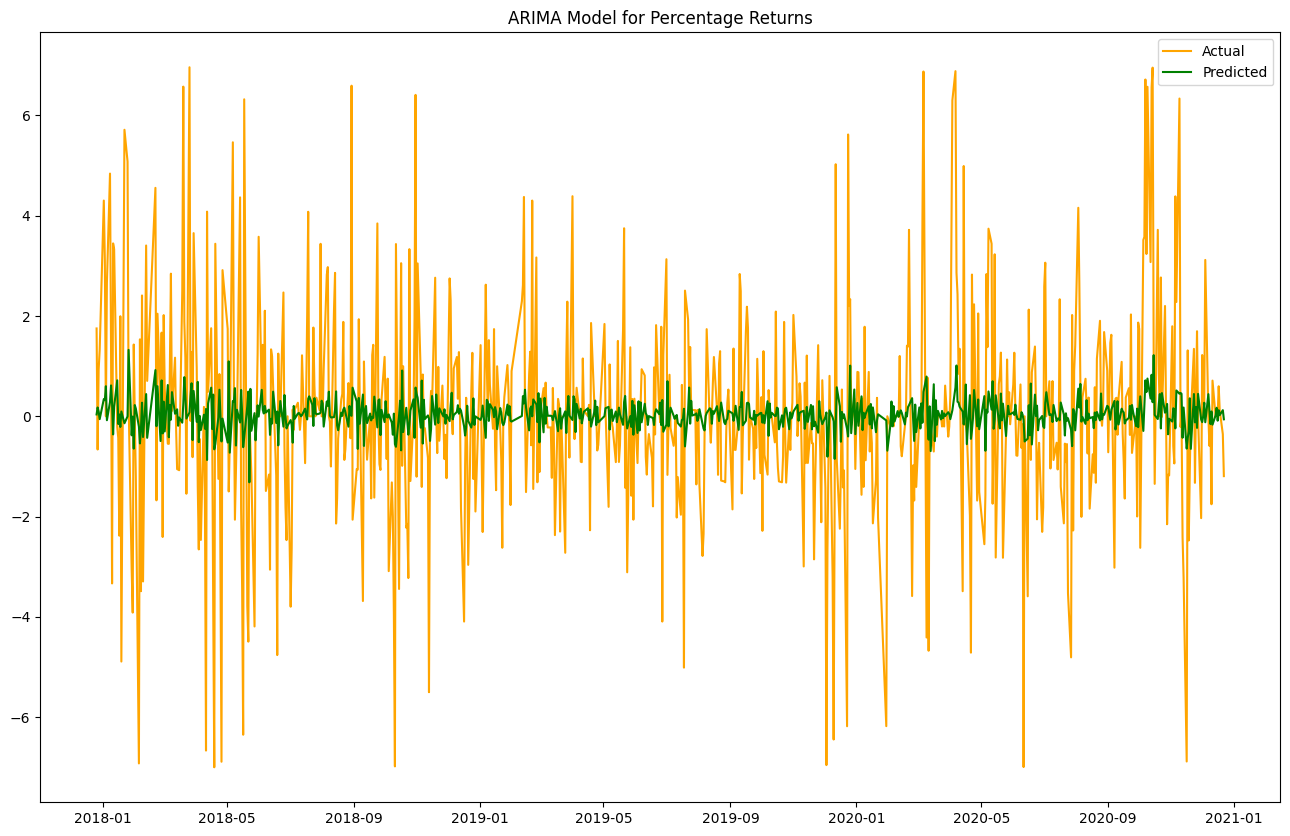

In [32]:
plt.figure(figsize= (16,10))
plt.title('ARIMA Model for Percentage Returns')
plt.plot(pct_returns, color= 'orange', label= 'Actual')
plt.plot(arima_predictions_02, color= 'green', label= 'Predicted')
plt.legend()
plt.show()

### 2.2. GARCH Model

In [33]:
max_p = 6
max_o = 6
max_q = 6

best_aic_02, best_params_02 = grid_search_garch(pct_returns, max_p, max_o, max_q, mean='constant', vol='garch', dist='t')

print(f"Best AIC: {best_aic_02}")
print(f"Best Parameters (p, o, q): {best_params_02}")

Best AIC: 3077.2268719613644
Best Parameters (p, o, q): (4, 1, 1)


In [34]:
garch_02 = arch_model(
    pct_returns, 
    p= 4, o= 1, q= 1, 
    mean = 'constant',
    vol = 'garch',
    dist = 't')
garch_model_02 = garch_02.fit(disp='off')
garch_model_02.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - GJR-GARCH Model Results                       
====================================================================================
Dep. Variable:           Percentage Returns   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -1529.61
Distribution:      Standardized Student's t   AIC:                           3077.23
Method:                  Maximum Likelihood   BIC:                           3118.77
                                              No. Observations:                  747
Date:                      Mon, Dec 04 2023   Df Residuals:                      746
Time:                              15:04:39   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.0736  5.434e-02     -1.354      0.176 [ -0.180,3.292e-02]
                             Volatility Model                             
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
omega          1.7770      0.594      2.990  2.793e-03   [  0.612,  2.942]
alpha[1]       0.3441      0.140      2.455  1.410e-02 [6.934e-02,  0.619]
alpha[2]       0.0358      0.121      0.296      0.767   [ -0.201,  0.273]
alpha[3]       0.0000  6.846e-02      0.000      1.000   [ -0.134,  0.134]
alpha[4]       0.2086  7.659e-02      2.724  6.450e-03 [5.851e-02,  0.359]
gamma[1]       0.3936      0.349      1.127      0.260   [ -0.291,  1.078]
beta[1]        0.1272      0.180      0.705      0.481   [ -0.226,  0.481]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             3.4046      0.535      6.361  2.007e-10 [  2.356,  4.454]
========================================================================

Covariance estimator: robust
"""

In [35]:
garch_result_02 = garch_model_02.conditional_volatility

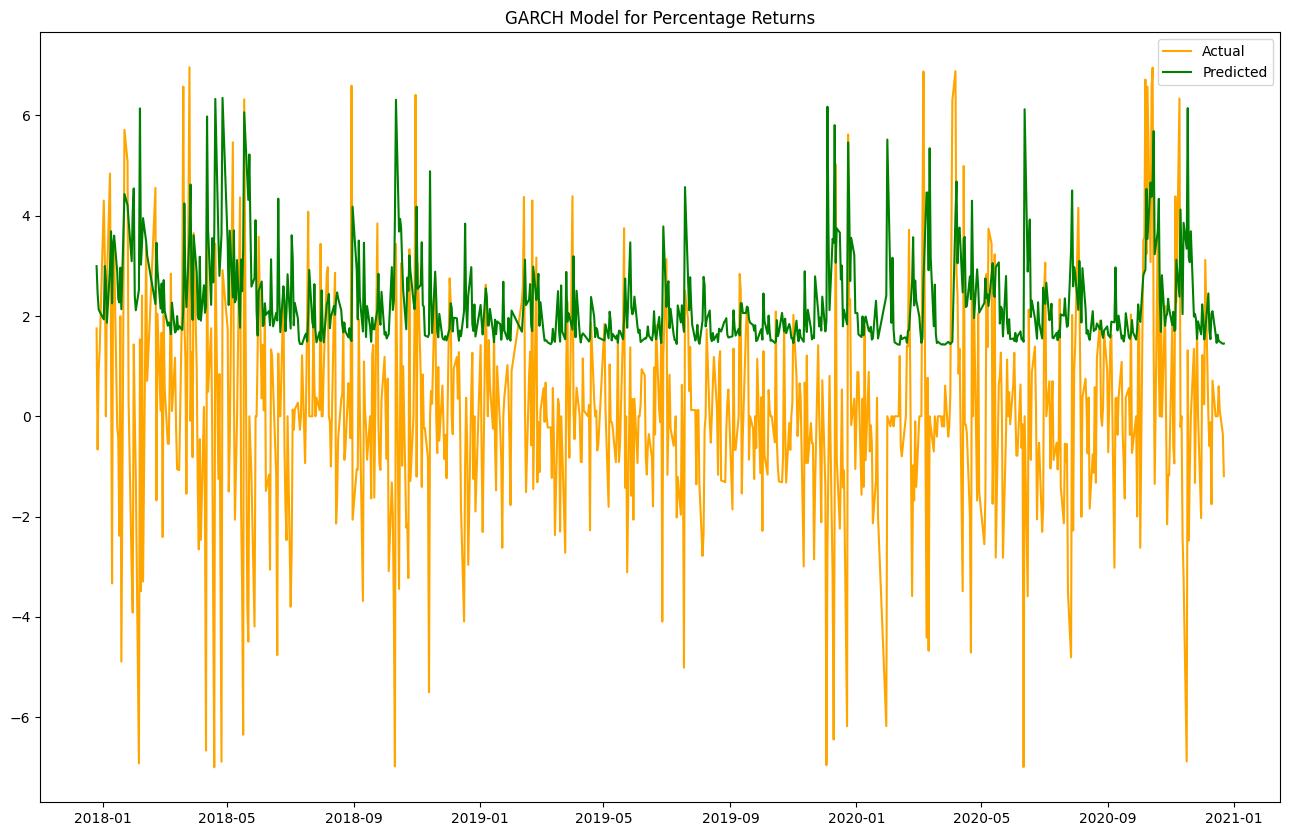

In [36]:
plt.figure(figsize= (16,10))
plt.title('GARCH Model for Percentage Returns')
plt.plot(pct_returns, color= 'orange', label= 'Actual')
plt.plot(garch_result_02, color= 'green', label= 'Predicted')
plt.legend()
plt.show()

### 2.3. ARIMA-GARCH Model

In [37]:
arima_residuals_02 = arima_model_02.resid

arima_garch_02 = arch_model(
    arima_residuals_02, 
    p= 4, o= 1, q= 1, 
    mean = 'constant',
    vol = 'garch',
    dist = 't')
arima_garch_model_02 = arima_garch_02.fit(disp='off')
arima_garch_model_02.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                      Constant Mean - GJR-GARCH Model Results                       
====================================================================================
Dep. Variable:                         None   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                        GJR-GARCH   Log-Likelihood:               -1532.18
Distribution:      Standardized Student's t   AIC:                           3082.36
Method:                  Maximum Likelihood   BIC:                           3123.90
                                              No. Observations:                  747
Date:                      Mon, Dec 04 2023   Df Residuals:                      746
Time:                              15:04:40   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu            -0.1111  6.480e-02     -1.714  8.644e-02 [ -0.238,1.591e-02]
                              Volatility Model                             
===========================================================================
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega          1.6873      0.805      2.097  3.601e-02    [  0.110,  3.265]
alpha[1]       0.3283      0.120      2.745  6.059e-03  [9.386e-02,  0.563]
alpha[2]       0.0000      0.145      0.000      1.000    [ -0.284,  0.284]
alpha[3]   1.5544e-12      0.213  7.310e-12      1.000    [ -0.417,  0.417]
alpha[4]       0.1783  9.449e-02      1.887  5.912e-02 [-6.863e-03,  0.364]
gamma[1]       0.3372      0.375      0.898      0.369    [ -0.399,  1.073]
beta[1]        0.1544      0.302      0.511      0.609    [ -0.438,  0.747]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             3.8284      0.909      4.213  2.515e-05 [  2.048,  5.609]
========================================================================

Covariance estimator: robust
"""

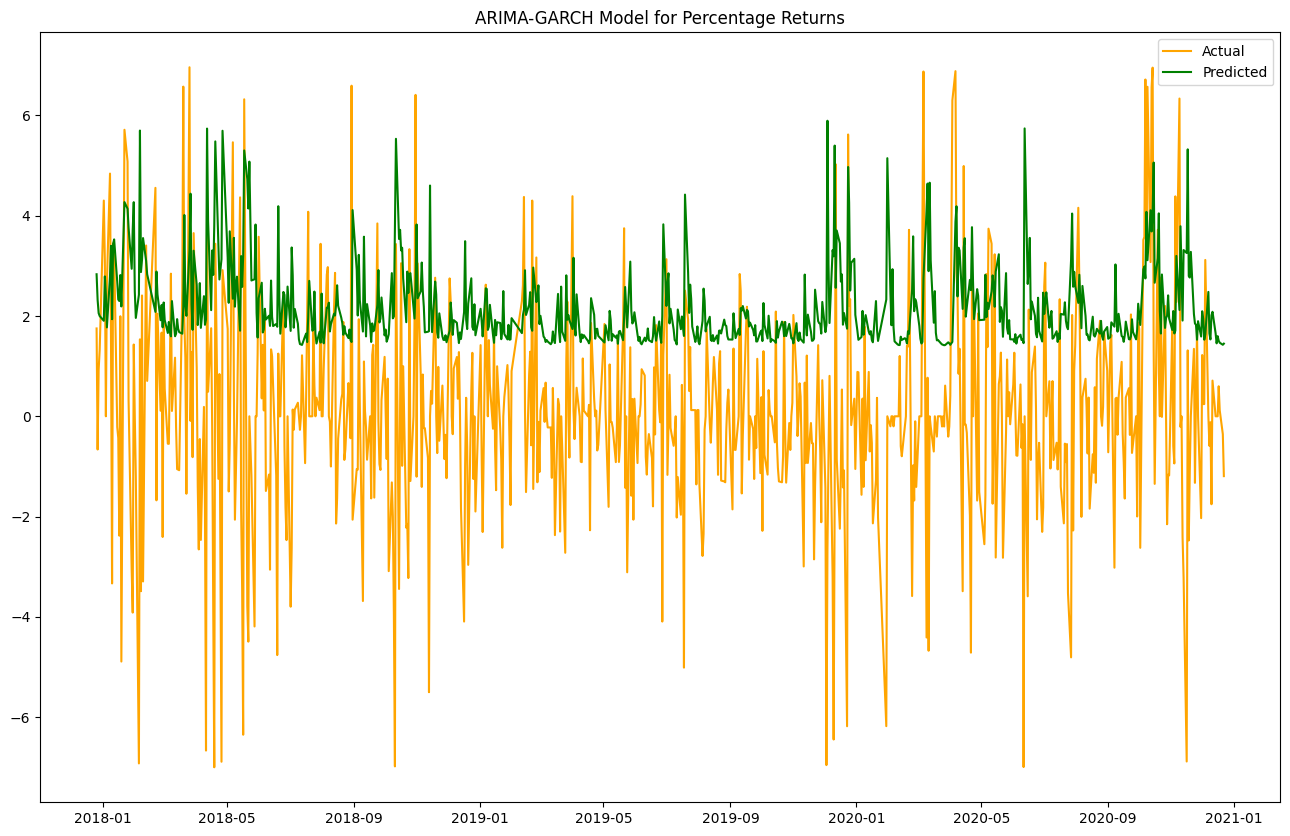

In [38]:
arima_garch_result_02 = arima_garch_model_02.conditional_volatility
plt.figure(figsize= (16,10))
plt.title('ARIMA-GARCH Model for Percentage Returns')
plt.plot(pct_returns, color= 'orange', label= 'Actual')
plt.plot(arima_garch_result_02, color= 'green', label= 'Predicted')
plt.legend()
plt.show()

### 2.4. Rolling ARIMA-GARCH Model

In [39]:
split_index = int(len(pct_returns) * 0.8)

train_pct_returns = pct_returns[:split_index]
test_pct_returns = pct_returns[split_index:]

In [40]:
window_size = 30

train_pct_returns_arr = train_pct_returns.values
test_pct_returns_arr = test_pct_returns.values

# Initialise lists with training data and predictions
history_pct_returns_arr = [x for x in train_pct_returns_arr]
rolling_predictions_02 = []

In [41]:
warnings.filterwarnings('ignore')

# Iterate through test data and make predictions
for t in range(len(test_pct_returns_arr)):
    # Fit ARIMA model on the most recent observations
    start = max(0, len(history_pct_returns_arr) - window_size)
    end = len(history_pct_returns_arr)
    # Fit the ARIMA model on the rolling window
    arima = ARIMA(history_pct_returns_arr[start:end], order=(1, 0, 2))
    arima_model = arima.fit()
    
    # Get the residuals from the ARIMA model
    arima_residuals = arima_model.resid
    
    # Fit the GARCH model to the ARIMA residuals
    arima_garch = arch_model(
        arima_residuals, 
        p= 4, o= 1, q= 1, 
        mean = 'constant',
        vol = 'garch',
        dist = 't')
    arima_garch_model = arima_garch.fit(disp='off')
    arima_garch_model.summary()


    # Make forecast and update lists
    output = arima_garch_model.forecast()
    rolling_volatility = np.sqrt(output.variance.values[-1,:][0])
    rolling_predictions_02.append(rolling_volatility)
    obs = test_pct_returns_arr[t]
    history_pct_returns_arr.append(obs)

c:\Users\Admins\AppData\Local\Programs\Python\Python311\Lib\site-packages\arch\univariate\base.py:765: ConvergenceWarning: The optimizer returned code 8. The message is:
Positive directional derivative for linesearch
See scipy.optimize.fmin_slsqp for code meaning.

  warnings.warn(


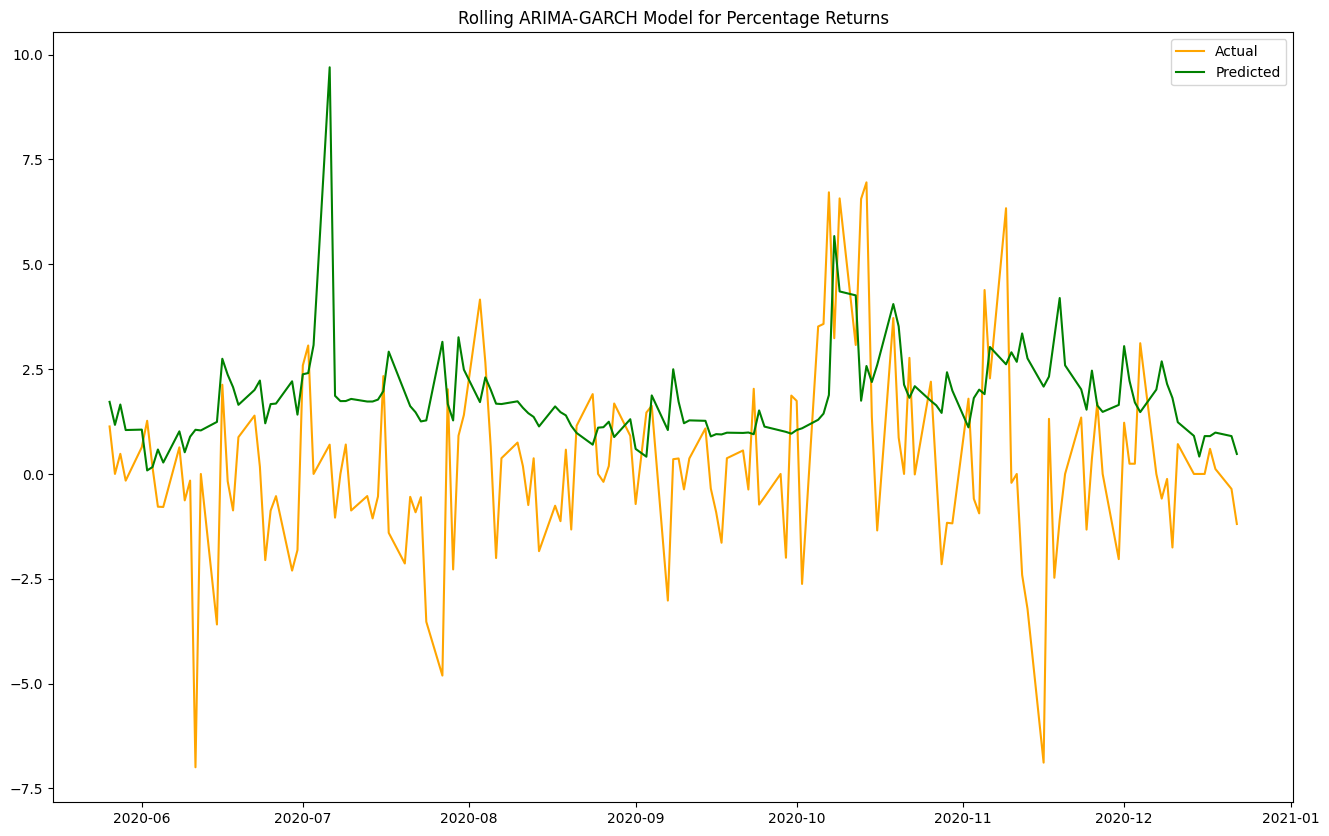

In [42]:
plt.figure(figsize= (16,10))
plt.title('Rolling ARIMA-GARCH Model for Percentage Returns')
plt.plot(test_pct_returns.index, test_pct_returns, color= 'orange', label= 'Actual')
plt.plot(test_pct_returns.index, rolling_predictions_02, color= 'green', label= 'Predicted')
plt.legend()
plt.show()